# Muon Profile
## Notebook for calculating the spatial distribution of muons along the beamline
Relies on https://github.com/makelat/forward-nu-flux-fit and https://arxiv.org/abs/2309.10417

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('figures.mplstyle')
import sys
sys.path.append("../forward-nu-flux-fit")
from Code import experiments
flux_path = '../forward-nu-flux-fit/files/'
import pandas as pd
from GeometryHelpers import *

In [2]:
def get_file(prefix,generator,parent):
    return flux_path + prefix + '_' + generator + '_' + parent + '_0.txt'

def angular_distribution(file,lumi=150):
    data = np.loadtxt(file)
    thx,thy,w = data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    bins = (np.linspace(-0.0015,0.0015,100))
    plt.hist2d(thx,thy,bins=bins,weights=w,)
    plt.xlabel(r'$\theta_x$ [rad]')
    plt.ylabel(r'$\theta_y$ [rad]')
    plt.show()

def position_distribution(file,lumi=150):
    data = np.loadtxt(file)
    x,y,w = data[:,2],data[:,3],data[:,-1]
    w *= 1000*lumi
    bins = (np.linspace(-2,2,100))
    plt.hist2d(x,y,bins=bins,weights=w)
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$y$ [m]')
    plt.show()

def angle_to_radius(x0,y0,thx,thy,posz):
    # x0 is location at z0 = 480m from ATLAS
    x = x0 + thx*(posz-480)
    y = y0 + thy*(posz-480)
    return np.sqrt(x**2+y**2)

def EnergyDistribution(file,experiment=None,lumi=150):
    data = np.loadtxt(file)
    x0,y0,thx,thy,E,w = data[:,2],data[:,3],data[:,5],data[:,6],data[:,-2],data[:,-1]
    if experiment is not None:
        x_exp = x0 + thx*(experiments[experiment]['posz']-480)
        y_exp = y0 + thy*(experiments[experiment]['posz']-480)

        fid_cut_x = np.logical_and(x_exp < experiments[experiment]['xmax'],
                                  x_exp > experiments[experiment]['xmin'])
        fid_cut_y = np.logical_and(y_exp < experiments[experiment]['ymax'],
                                  y_exp > experiments[experiment]['ymin'])
        fid_cut = np.logical_and(fid_cut_x, fid_cut_y)
        return E[fid_cut],w[fid_cut]*1000*lumi
    return E,w*1000*lumi
    

def FluxRatio(file,experiment,radius_arr,posz=10000):
    data = np.loadtxt(file)
    x0,y0,thx,thy,w = data[:,2],data[:,3],data[:,5],data[:,6],data[:,-1]
    x_exp = x0 + thx*(experiments[experiment]['posz']-480)
    y_exp = y0 + thy*(experiments[experiment]['posz']-480)
    x_geneva = x0 + thx*(posz-480)
    y_geneva = y0 + thy*(posz-480)
    r_geneva = np.sqrt(x_geneva**2 + y_geneva**2)
    fid_cut_x = np.logical_and(x_exp < experiments[experiment]['xmax'],
                              x_exp > experiments[experiment]['xmin'])
    fid_cut_y = np.logical_and(y_exp < experiments[experiment]['ymax'],
                              y_exp > experiments[experiment]['ymin'])
    rate_exp = np.sum(w[np.logical_and(fid_cut_x, fid_cut_y)])
    ratio_arr = []
    for radius in radius_arr:
        fid_cut_r = r_geneva < radius
        rate_geneva = np.sum(w[fid_cut_r])
        ratio_arr.append(rate_geneva/rate_exp)
    return ratio_arr


def pseudorapidity_distribution(file,ax,lumi=150,label=None):
    data = np.loadtxt(file)
    thx,thy,w = data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    costh = np.sqrt(1 - np.sin(thx)**2 - np.sin(thy)**2)
    eta = -np.log(np.sin(np.arccos(costh))/(1 + costh))
    ax.hist(eta,weights=w,bins=np.linspace(6,12,30),histtype='step',label=label)

def radial_distribution(file,ax,lumi=150,posz=10000,label=None):
    data = np.loadtxt(file)
    x0,y0,thx,thy,w = data[:,2],data[:,3],data[:,5],data[:,6],data[:,-1]
    w *= 1000*lumi
    r = angle_to_radius(x0,y0,thx,thy,posz=posz)
    ax.hist(r,weights=w,bins=np.linspace(0,np.max(r),100),histtype='step',label=label)



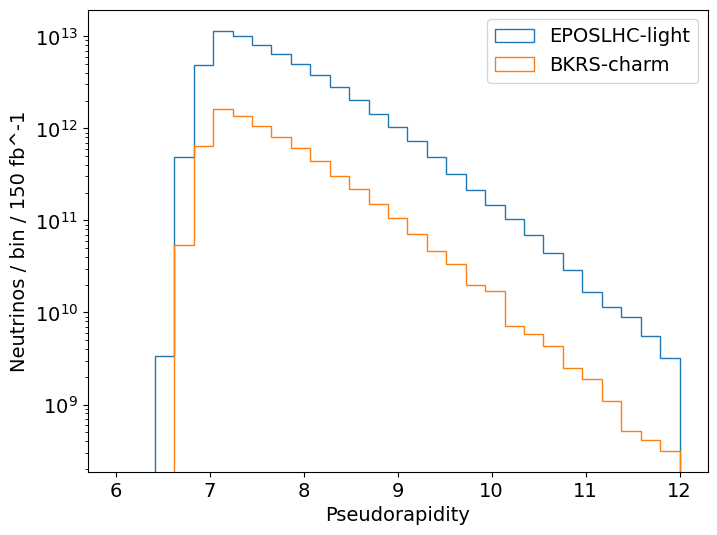

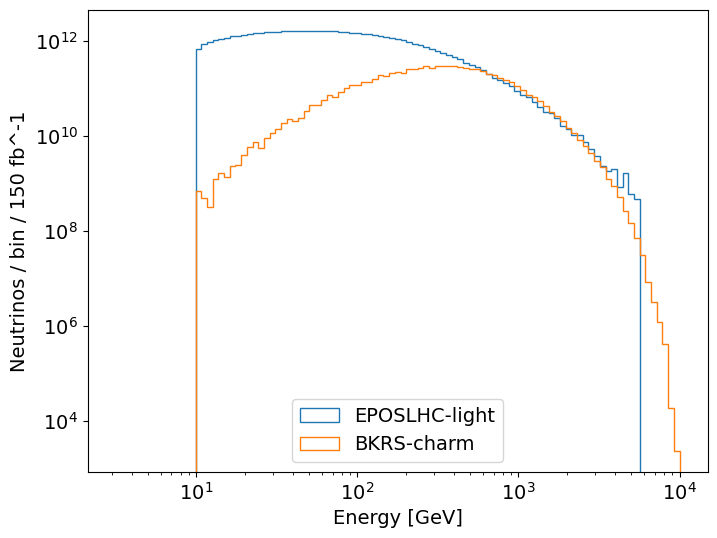

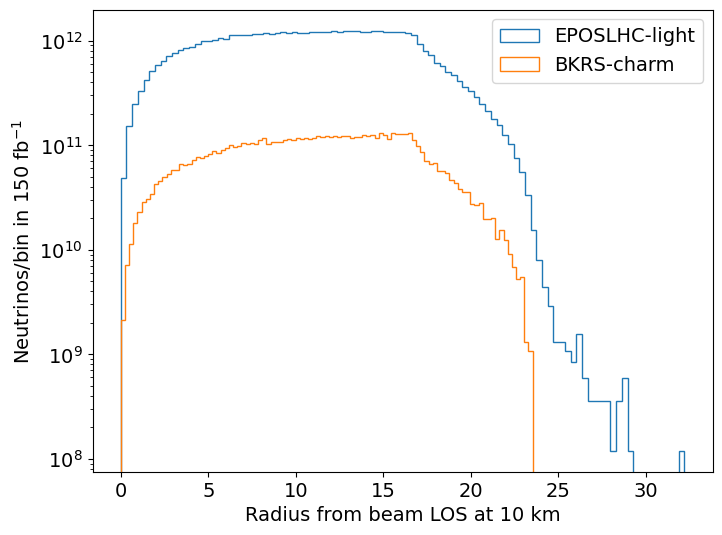

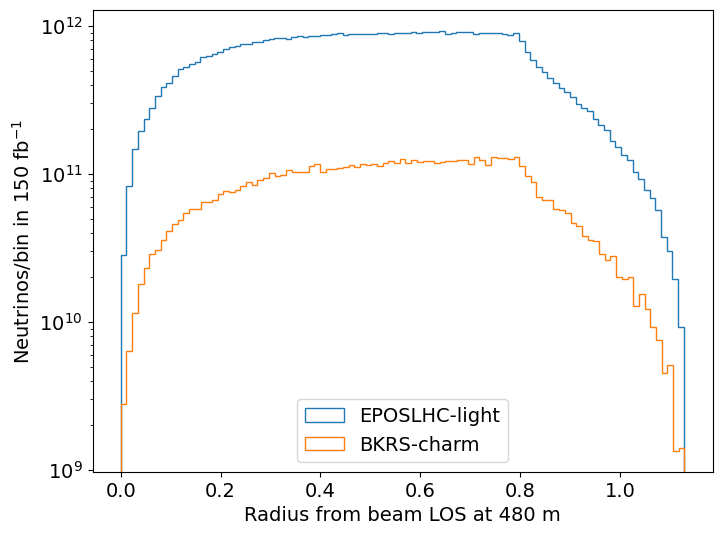

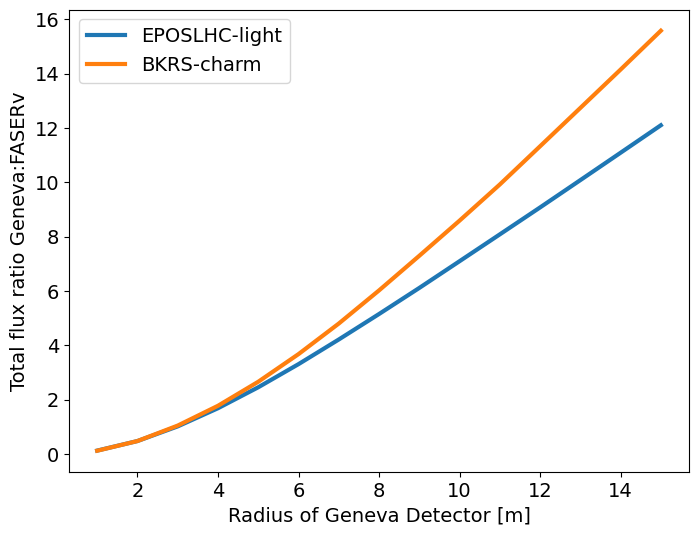

In [4]:
# angular_distribution(get_file('LHC13','SIBYLL','light'))
# position_distribution(get_file('LHC13','SIBYLL','light'))
# angular_distribution(get_file('Large','EPOSLHC','light'))
# position_distribution(get_file('Large','EPOSLHC','light'))
# angular_distribution(get_file('Large','BKRS','charm'))
# position_distribution(get_file('Large','BKRS','charm'))

fig = plt.figure()
ax1 = fig.add_subplot(111)
#pseudorapidity_distribution(get_file('LHC13','SIBYLL','light'),ax1)
pseudorapidity_distribution(get_file('Large','EPOSLHC','light'),ax1,label='EPOSLHC-light')
pseudorapidity_distribution(get_file('Large','BKRS','charm'),ax1,label='BKRS-charm')
plt.xlabel('Pseudorapidity')
plt.legend()
plt.semilogy()
plt.ylabel('Neutrinos / bin / 150 fb^-1')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
bins = np.logspace(0.5,4,100)
# E,W = EnergyDistribution(get_file('LHC13','SIBYLL','light'),'FASERv')
# plt.hist(E,weights=W,bins=np.logspace(1,4,30),histtype='step')
E,W = EnergyDistribution(get_file('Large','EPOSLHC','light'))
plt.hist(E,weights=W,bins=bins,histtype='step',label='EPOSLHC-light')
E,W = EnergyDistribution(get_file('Large','BKRS','charm'))
plt.hist(E,weights=W,bins=bins,histtype='step',label='BKRS-charm')
plt.xlabel('Energy [GeV]')
plt.ylabel('Neutrinos / bin / 150 fb^-1')
plt.loglog()
plt.legend()
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
#radial_distribution(get_file('LHC13','SIBYLL','light'),ax1,label='SIBYLL-light')
#radial_distribution(get_file('VLarge','EPOSLHC','light'),ax1,label='VLarge EPOSLHC-light')
#radial_distribution(get_file('VLarge','BKRS','charm'),ax1,label='VLarge BKRS-charm')
radial_distribution(get_file('Large','EPOSLHC','light'),ax1,label='EPOSLHC-light')
radial_distribution(get_file('Large','BKRS','charm'),ax1,label='BKRS-charm')
plt.xlabel('Radius from beam LOS at 10 km')
plt.ylabel(r'Neutrinos/bin in 150 fb$^{-1}$')
plt.legend()
plt.semilogy()
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
#radial_distribution(get_file('LHC13','SIBYLL','light'),ax1,posz=480,label='SIBYLL-light')
#radial_distribution(get_file('VLarge','EPOSLHC','light'),ax1,posz=480,label='VLarge EPOSLHC-light')
#radial_distribution(get_file('VLarge','BKRS','charm'),ax1,posz=480,label='VLarge BKRS-charm')
radial_distribution(get_file('Large','EPOSLHC','light'),ax1,posz=480,label='EPOSLHC-light')
radial_distribution(get_file('Large','BKRS','charm'),ax1,posz=480,label='BKRS-charm')
plt.xlabel('Radius from beam LOS at 480 m')
plt.ylabel(r'Neutrinos/bin in 150 fb$^{-1}$')
plt.legend()
plt.semilogy()
plt.show()
plt.close(fig)

radius_arr = np.linspace(1,15,15)
ratio_arr = {}
ratio_arr['EPOSLHC-light'] = FluxRatio(get_file('Large','EPOSLHC','light'),'FASERv',radius_arr)
ratio_arr['BKRS-charm'] = FluxRatio(get_file('Large','BKRS','charm'),'FASERv',radius_arr)
#ratio_arr['Vlight'] = FluxRatio(get_file('VLarge','EPOSLHC','light'),'FASERv',radius_arr)
#ratio_arr['Vcharm'] = FluxRatio(get_file('VLarge','BKRS','charm'),'FASERv',radius_arr)
for k in ratio_arr.keys():
    plt.plot(radius_arr,ratio_arr[k],label=k)
plt.xlabel('Radius of Geneva Detector [m]')
plt.ylabel('Total flux ratio Geneva:FASERv')
plt.legend()
plt.show()

# Import DIS cross section with leptoninjector

In [ ]:
def SampleSecondaryMomenta(neutrino_momenta):

    random = LI.utilities.LI_random()
    
    record = LI.dataclasses.InteractionRecord()
    record.signature.primary_type = primary_type
    record.signature.target_type = target_type
    record.target_mass = 1
    sec_types = [LI.dataclasses.Particle.MuMinus,LI.dataclasses.Particle.Hadrons]
    record.signature.secondary_types = sec_types
    muon_momenta = np.empty(neutrino_momenta.shape)
    target_momenta = np.empty(neutrino_momenta.shape)
    for i,momentum in enumerate(neutrino_momenta):
        print('%d/%d'%(i,len(neutrino_momenta)),end='\r')
        record.primary_momentum = momentum
        DIS_xs.SampleFinalState(record,random)
        muon_momenta[i] = (record.secondary_momenta[0])
        target_momenta[i] = (record.secondary_momenta[1])
    return np.array(muon_momenta),np.array(target_momenta)
    

In [ ]:

kwargs = {'bins':np.logspace(-1,4,100),
          'histtype':'step'}

momenta = GetNeutrinoMomenta(get_file('Large','EPOSLHC','light'))[:20000]
muon_momenta,target_momenta = SampleSecondaryMomenta(momenta)
plt.hist(momenta[:,0],color='r',label='neutrino',**kwargs)
plt.hist(muon_momenta[:,0],color='b',label='muon',**kwargs)
plt.hist(target_momenta[:,0],color='g',label='target',**kwargs)

kwargs['ls'] = '--'

momenta = GetNeutrinoMomenta(get_file('Large','BKRS','charm'))[:20000]
muon_momenta,target_momenta = SampleSecondaryMomenta(momenta)
plt.hist(momenta[:,0],color='r',**kwargs)
plt.hist(muon_momenta[:,0],color='b',**kwargs)
plt.hist(target_momenta[:,0],color='g',**kwargs)

plt.plot([],[],color='black',label=r'$\pi,K$')
plt.plot([],[],color='black',ls='--',label=r'$D,\Lambda_c$')

plt.xlabel('Energy [GeV]')
plt.ylabel('Number of Generated Events per Bin')
plt.loglog()
plt.legend()
plt.show()



In [ ]:
LHC_data = pd.read_parquet('Data/LHC_data.parquet')
Lake_data = pd.read_parquet('Data/Lake_data.parquet')

# Define the LHC circle
LHC = Circle(np.array(LHC_data.loc['Point4',['X','Y','Z']]),
             np.array(LHC_data.loc['LHCb',['X','Y','Z']]),
             np.array(LHC_data.loc['Point6',['X','Y','Z']])) # last entry can be Point 2 or 6

# Fix elevation of other LHC interaction points based on LHC circle definition
for k in list(LHC_data.index):
    elev,point = LHC.find_elevation(*np.array(LHC_data.loc[k,['Latitude','Longitude']]))
    LHC_data['Elevation'][k] = elev
    LHC_data.loc[k,['X','Y','Z']] = lat_long_to_xyz(*LHC_data.loc[k,['Latitude','Longitude','Elevation']])

k = 'LHCb'
muon_dirs = []
for muon_momentum in muon_momenta:
    muon_dirs.append(muon_momentum[1:]/np.linalg.norm(muon_momentum[1:]))
    
int1_list,int2_list = calculate_intersections_with_lake(LHC,
                                                        np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                        np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                        np.array(Lake_data[['Latitude','Longitude']]),
                                                        particle_unit_dirs=muon_dirs,
                                                        limit=50000000)

In [ ]:
Lake_Crossings = []
for int1,int2 in zip(int1_list,int2_list):
    for intersections in (int1,int2):
            if(type(intersections) == shapely.geometry.MultiLineString):
                for intersection in intersections.geoms:
                    for coord in list(intersection.coords):
                        Lake_Crossings.append(coord)
            else:
                for coord in list(intersections.coords):
                    Lake_Crossings.append(coord)
Lake_Crossings = np.array(Lake_Crossings)

In [ ]:
plt.scatter(Lake_Crossings[:,1],Lake_Crossings[:,0])